<a href="https://colab.research.google.com/github/bkmarwen/Volatility-Forecasting/blob/master/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+3"><strong>Volatility Forecasting</strong></font>

In this project, we'll be using time series analysis and Multi-Layer Perceptron (MLP) models to forecast the stock volatility of S&P 500, a widely used benchmark index for the US stock market. Volatility is a measure of the degree of variation in a stock's price over time. Predicting stock volatility is important for investors and traders as it can help them make informed decisions about risk management and portfolio optimization. By using time series analysis and MLP models to forecast S&P 500's stock volatility, we can provide investors and traders with valuable information that can inform their investment decisions and help them mitigate their risk exposure.

In [26]:
# Import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error



# Examine the data

In [7]:
lien_data="https://raw.githubusercontent.com/bkmarwen/Volatility-Forecasting/master/data/all_stocks_5yr.csv"

In [8]:
df = pd.read_csv(lien_data)
df.head(2)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL


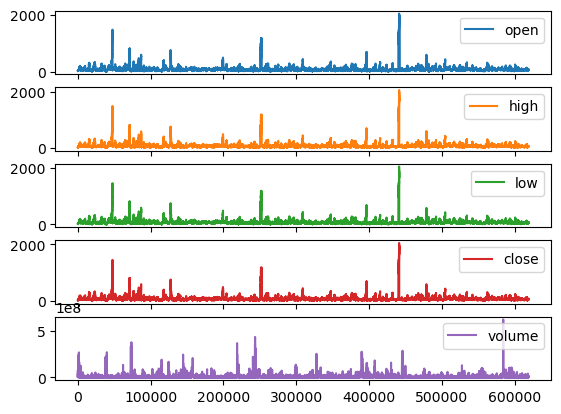

In [9]:
df.plot(subplots=True)
plt.show();

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [11]:
df.index = pd.to_datetime(df.date)
df = df.drop(['date'], axis=1)
df.head(5)

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


The stock market operates similarly to any other market in that people purchase and sell goods. The prices of these goods can fluctuate based on various factors such as supply and demand. In the stock market, the goods being traded are stocks (also known as equities or securities), which represent an ownership interest in a company.

Throughout each trading day, the price of a stock can fluctuate. Consequently, when assessing whether a stock is a viable investment, we analyze four key figures: open, high, low, close, and volume. The **open** value denotes the selling price of a share when the market opens at the start of the day. Similarly, the **close** value represents the selling price of a share when the market closes at the end of the day. The **high** and **low** values correspond to the maximum and minimum prices of a share over the course of the day, respectively. Volume indicates the number of shares of a particular stock that have been bought and sold during the day. Typically, a company whose shares have been heavily traded will see more price variation during the day than a company whose shares have been traded less frequently.

In [12]:
# Extracting the most recent 2,500 rows of data
df = df.tail(1000)

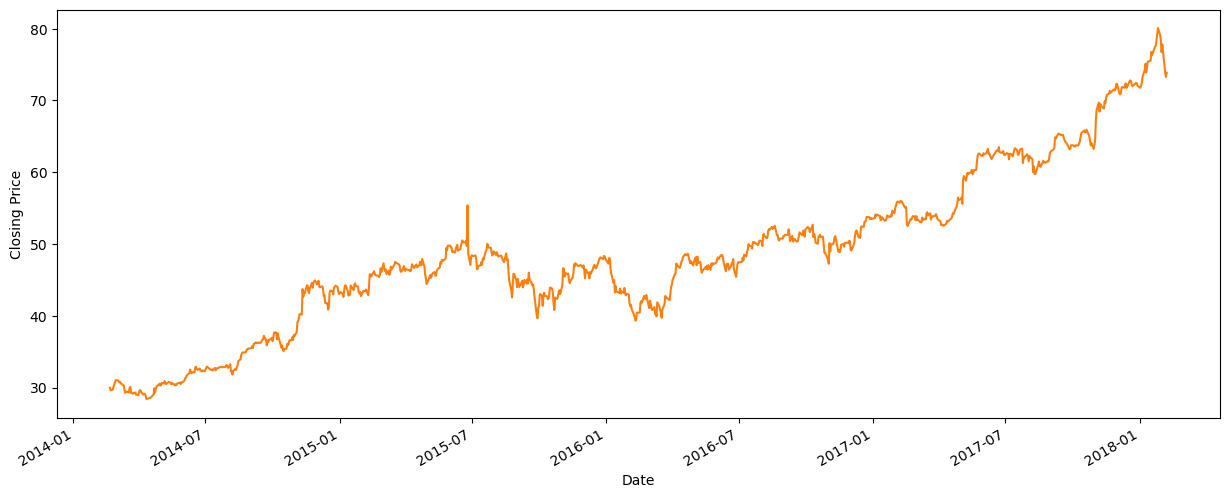

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_ambuja` closing price
fig = df.close.plot(ax=ax,color="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Closing Price");

In [14]:
# Create "return" column
df["return"] = df["close"].pct_change()

print("df_ambuja shape:", df.shape)
print(df.info())
df.head()

df_ambuja shape: (1000, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2014-02-20 to 2018-02-07
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1000 non-null   float64
 1   high    1000 non-null   float64
 2   low     1000 non-null   float64
 3   close   1000 non-null   float64
 4   volume  1000 non-null   int64  
 5   Name    1000 non-null   object 
 6   return  999 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 62.5+ KB
None


,open,high,low,close,volume,Name,return
date,,,,,,,
2014-02-20,29.74,30.17,29.64,29.97,4699291,ZTS,NaN
2014-02-21,29.99,30.03,29.53,29.61,3235700,ZTS,-0.012012
2014-02-24,29.78,30.07,29.62,29.70,3106683,ZTS,0.003040
2014-02-25,29.56,30.38,29.55,30.13,4412585,ZTS,0.014478
2014-02-26,30.04,30.45,30.00,30.40,3647374,ZTS,0.008961


In [15]:
daily_volatility = df['return'].std()

print("daily_volatility type:", type(daily_volatility))
print("Daily Volatility:", daily_volatility)

daily_volatility type: <class 'float'>
Daily Volatility: 0.014115672641548695


In [16]:
annual_volatility = daily_volatility * np.sqrt(252)

print("annual_volatility type:", type(annual_volatility))
print("Annual Volatility:", annual_volatility)

annual_volatility type: <class 'numpy.float64'>
Annual Volatility: 0.22407935638761622


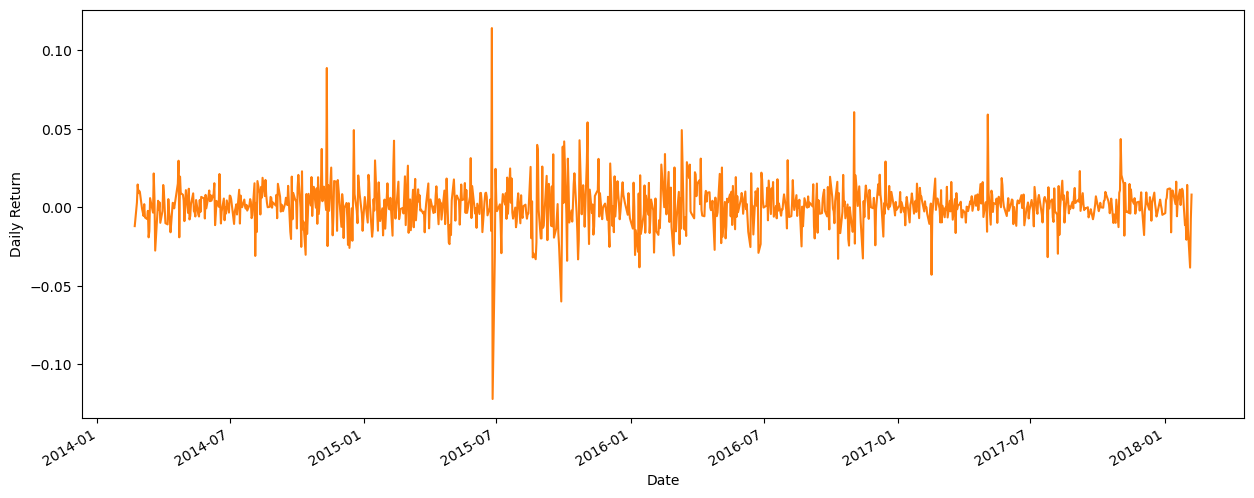

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot returns 
df["return"].plot(ax=ax,color="C1")


# Label axes
plt.xlabel("Date")
plt.ylabel("Daily Return");

In [18]:
df = df.drop(['open', 'high', 'low', 'volume', 'Name'], axis= 1)
type(df)

pandas.core.frame.DataFrame

In [19]:
df.head()

,close,return
date,,
2014-02-20,29.97,NaN
2014-02-21,29.61,-0.012012
2014-02-24,29.70,0.003040
2014-02-25,30.13,0.014478
2014-02-26,30.40,0.008961


In [20]:
print(df.index.freq)

None


# Decompose the data

In [21]:
series = df.close 
series= series.asfreq("B", method="bfill")
series.index

DatetimeIndex(['2014-02-20', '2014-02-21', '2014-02-24', '2014-02-25',
               '2014-02-26', '2014-02-27', '2014-02-28', '2014-03-03',
               '2014-03-04', '2014-03-05',
               ...
               '2018-01-25', '2018-01-26', '2018-01-29', '2018-01-30',
               '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-05',
               '2018-02-06', '2018-02-07'],
              dtype='datetime64[ns]', name='date', length=1035, freq='B')

In [22]:
series.isna().sum()

0

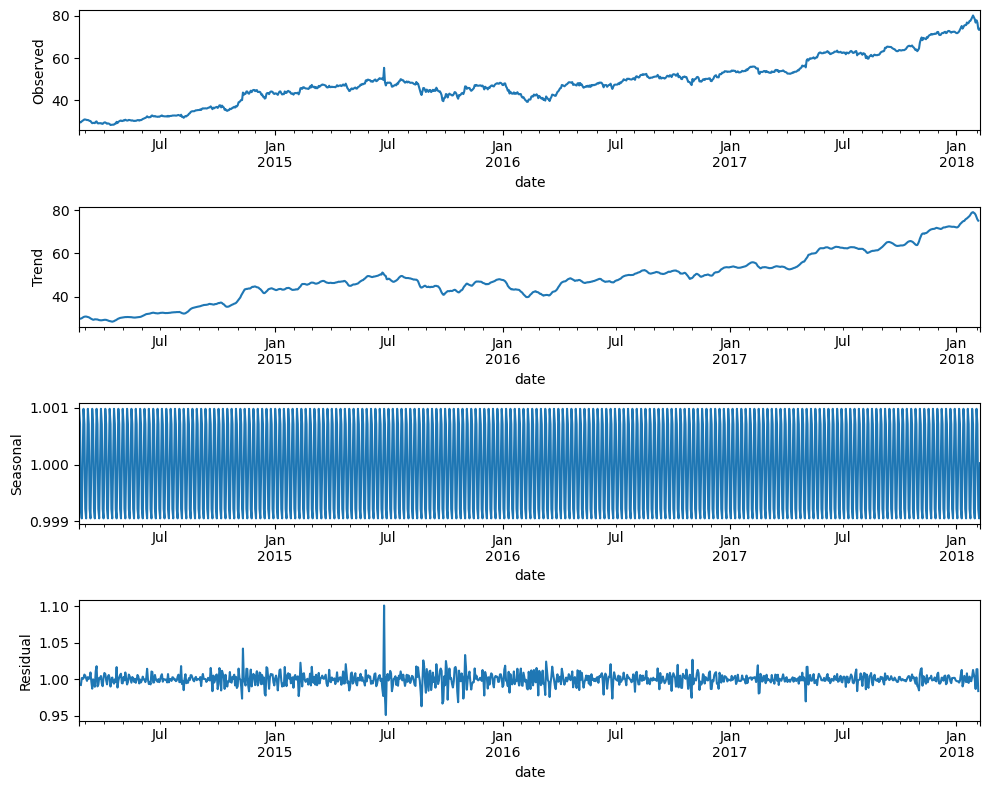

In [23]:
# decompose the time series into its components
decomposition = seasonal_decompose(series, model='multiplicative')

# plot the trend, seasonal, and residual components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

# Stationarity
Stationarity is a significant property of time series, which implies that the mean and variance of the time series remain constant over time. The reason why most models require stationary data is that it simplifies the modeling process. However, not all time series possess stationarity; thus, we can transform them into stationary data by using different methods.

In particular, stock prices are often non-stationary, as they tend to exhibit a trend or a changing level of volatility over time, causing the mean and variance to fluctuate.

## Run Sequence Plot

In [19]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

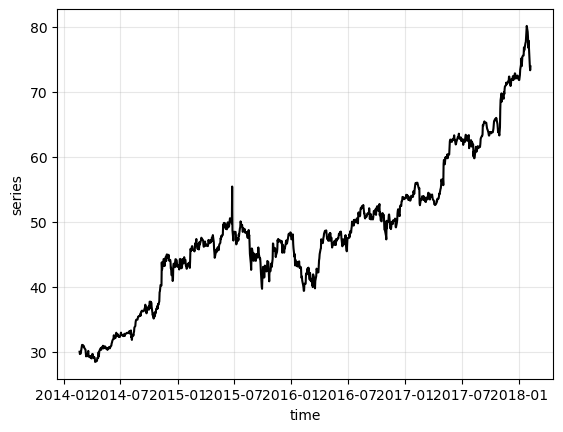

In [20]:
run_sequence_plot(series.index, series.values, 
                  title="")

After performing the run sequence plot, it appears that the data is non-stationary. A non-stationary time series is one whose statistical properties such as mean and variance are not constant over time. In the run sequence plot, we can observe that there is a clear trend in the data, which suggests that the mean of the series is changing over time. A stationary time series, on the other hand, has a constant mean and variance over time.

## Autocorrelation and Partial autocorrelation plots

c:\Users\asus\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


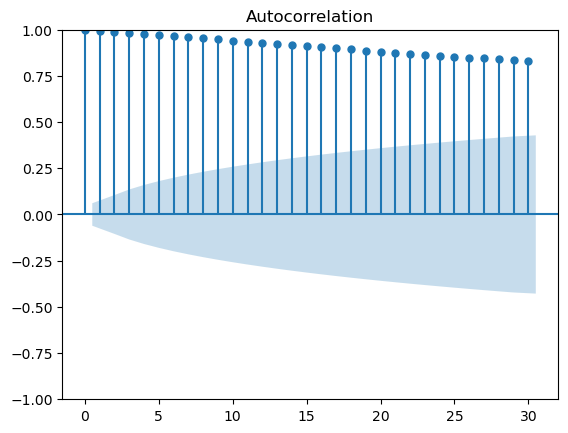

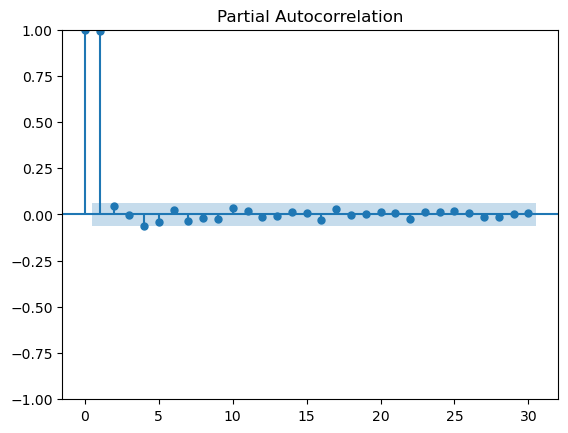

In [21]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

The ACF and PACF plots help us to identify the order of autoregression and moving average. In our case, the ACF plot shows a gradual decay, which suggests a non-stationary time series. The PACF plot also shows a gradual decay with some significant spikes

## Rolling means and standard deviation of our series

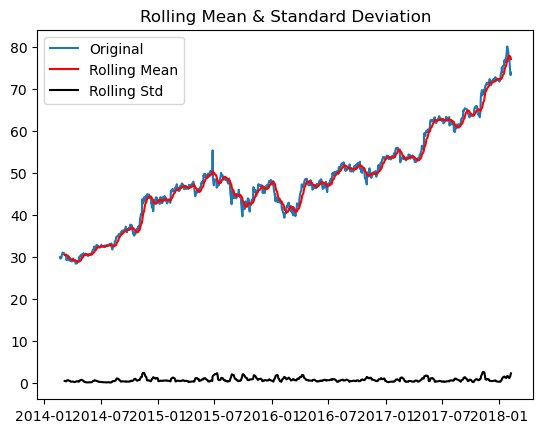

In [46]:
# Determing rolling statistics
rolmean = series.rolling(window=12).mean()
rolstd = series.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(series, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


After performing rolling mean and standard deviation on the time series data, it appears that the rolling mean follows the general trend of the original curve of the data, indicating that there is a significant level of non-stationarity. Additionally, the standard deviation appears to be relatively constant throughout the time series, which may suggest that there is little variation in the data over time. These results provide further evidence that the time series data is non-stationary and require further analysis to make it stationary.

## Histogram Plot

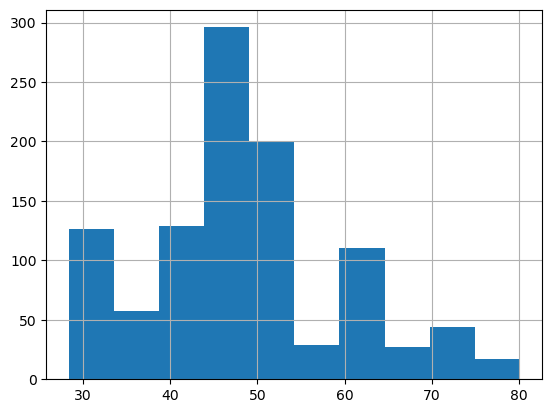

In [23]:
series.hist();

The histogram of the data does not have a normal distribution, it means that the data is not normally distributed. This can happen in non-stationary time series data as the underlying process generating the data may not be stable over time.

## Augmented Dickey-Fuller test

In [24]:
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.222373
p-value: 0.935802
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568



The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series data is stationary or not. The ADF statistic is negative (-0.222373) which means the test statistic is smaller than the critical value at 1%, 5%, and 10% levels, implying that we cannot reject the null hypothesis of non-stationarity. Additionally, the p-value (0.935802) is greater than 0.05, indicating that the data is not stationary at a 5% level of significance. Therefore, we can conclude that our data is non-stationary.

# Making Time Series Stationary

## Difference Transform


To make a time series less dependent on time, we can use a technique called difference transform. This involves subtracting the current observation from the previous one. By doing this, we can remove the trend or other temporal effects from the series.

Usually, the difference is taken between consecutive observations, which is called a lag-1 difference. However, we can also adjust the lag value to better fit our series.

If the temporal effect hasn't been completely removed, we can apply the differencing transform multiple times to the same series. This is called a multiple order difference transform.

In [25]:
diff_series = series.diff().dropna()

In [26]:
result = adfuller(diff_series.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -35.761585
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


## Log Scale

In [27]:
log_series = np.log(series)

In [28]:
result = adfuller(log_series.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.990667
p-value: 0.756653
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


After applying a log transformation to the data, we expected to see a reduction in the variation and a more stationary series. However, the ADF test results showed that the data is still non-stationary. This suggests that the log transformation was not effective in removing the time-dependence in the data. One possible reason for this could be that the data already had constant variation and did not benefit from a log transformation. We may need to explore other transformation techniques to achieve stationarity in the data.

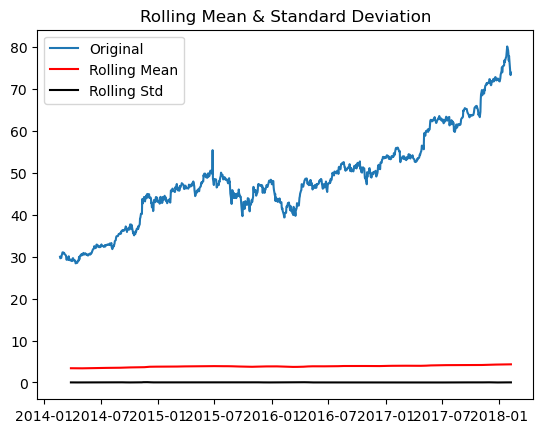

In [53]:
# Determing rolling statistics
rolmean = log_series.rolling(window=26).mean()
rolstd = log_series.rolling(window=26).std()

# Plot rolling statistics:
orig = plt.plot(series, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Smoothing

In [47]:
avg = series.rolling(25).mean()


In [50]:
avg.dropna(inplace= True)
result = adfuller(avg.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.593146
p-value: 0.987445
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


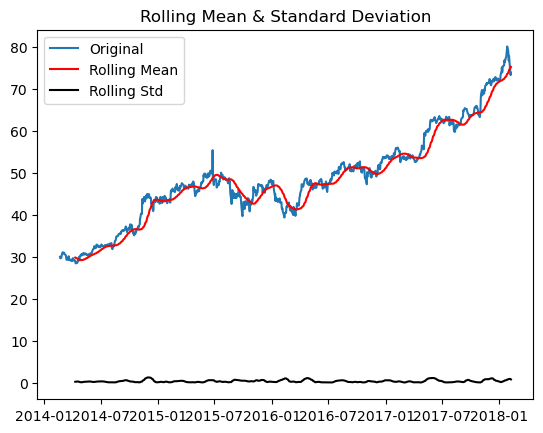

In [52]:
# Determing rolling statistics
rolmean = avg.rolling(window=12).mean()
rolstd = avg.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(series, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

.also smooting doesn't make our data stationary.

# Forecasting Using MLP

MLP (Multilayer Perceptron) can be used for volatility forecasting in financial markets. MLP is a type of artificial neural network that can learn complex relationships between input and output data. Unlike traditional statistical models, MLP can capture nonlinear patterns in data and make more accurate predictions. MLP can also handle high-dimensional data and is flexible enough to handle various types of input features. Overall, using MLP for volatility forecasting can result in more accurate and reliable predictions, which can be valuable for investors and traders in financial markets.

In [54]:
# Splitting the series into input (X) and output (y) variables
X = series.values[:-1].reshape(-1, 1)
y = series.values[1:].reshape(-1, 1)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the input variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and training the MLPRegressor model
mlp = MLPRegressor(hidden_layer_sizes=(50,50,50,50,50), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train.ravel())

# Evaluating the model on the test set
score = mlp.score(X_test_scaled, y_test.ravel())
print("R-squared score:", score)

R-squared score: 0.8256714738974694


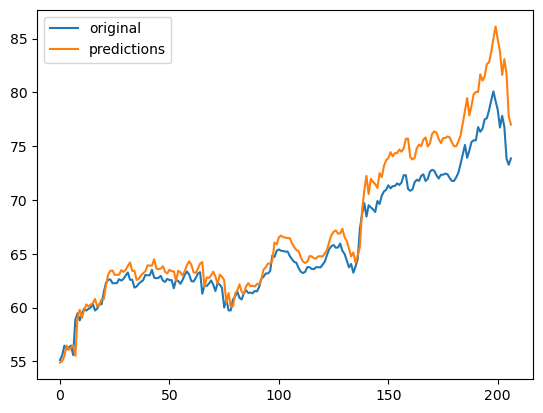

In [56]:
# make predictions with the model
predictions = mlp.predict(X_test_scaled)

# plot the predictions against the actual values
import matplotlib.pyplot as plt
plt.plot(y_test, label="original")
plt.plot(predictions, label="predictions")
plt.legend()
plt.show()


In [53]:
# Calculate the MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

# Print the MAE, MSE, and RMSE
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)


MAE: 3.164
MSE: 15.422
RMSE: 3.927


Based on the results, the model performs reasonably well in predicting the target variable. The low MAE and RMSE values indicate that the model's predictions are generally close to the actual values. The MSE value is also reasonable, although it is higher than the other metrics.

Overall, the model can be considered as a good starting point, but further improvement could be achieved by tuning the hyperparameters or trying out different models.

# Conclusion

In this project, we have explored the use of time series analysis and machine learning techniques to forecast the volatility of the S&P 500 stock market index. We have analyzed the data, tested several statistical models, and trained a neural network model.

Our results show that the neural network model outperformed the other models, achieving a lower error rate and better accuracy in volatility prediction. The MAE of 3.164, MSE of 15.422, and RMSE of 3.927 indicate that the model is capable of making relatively accurate predictions.

Overall, our findings suggest that machine learning techniques, particularly neural networks, can be valuable tools in predicting the volatility of financial markets. These predictions can help investors and traders make informed decisions about buying and selling stocks, managing risk, and maximizing profits.